# Indeed.com - Job Description Analyis
I will use NLP (natural language processing) to analyse job adverts scraped from the uk.Indeed.com jobs website

I will focus on UK based jobs in the data industry, mainly in Scottish companies to start with, keeping the data gathering steps manageable, possibly expanding the study to the rest of the UK later.

I will write my own web scraper using the Requests and BeautifulSoup libraries.  I plan to process the text data using the nltk library

## Motivation
Suppose I am running a hypothetical data analytics company.  I have been approached by another company who are hoping to build and recruit a data analytics team.  Since they don't have an existing data analytics team, I have been given a list of skills and experience they think they need.  My challenge is to classify what job title they should be marketing their vacancy for.  Should it be a Data Scientist, or a Data Engineer etc.

I am also (hypothetically) working with candidates to best tailor their CV, project portfolio etc to optimise for the things that data industry recruiters are looking for.  My study should be able to generate a list of the key things for each of the major data professions.

## Sections (rough outline)
- Scrape the data
- Data cleaning
- Data exploration
  - Extracting the list of top skills requirements for each of the main disciplines
  - Picking out common phrases to reference in an optimised CV
- Feature engineering
  - Job description length
  - Years of experience mentioned
  - Salary range (if enough data available)
  - Key tech stack tools included, cloud platforms, databases, NLP, dashboards etc.
  - Mentioning remote, flexible working etc
- Model Building
  - Classifier for labelling a job ad, with the most approproate job title.
  - Na   svieve Bayes
- Model Tuning



In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import pprint
import os
import indeed.IndeedScraper as ind
from wordcloud import WordCloud


# Scrape the data

In [2]:
# Manually trigger running the scraper or just loading existing data
scrape_new = False

f_name = 'data/data.csv'
if scrape_new or not os.path.isfile(f_name):
    ind.batch_scrape([('Data Scientist', 'Scotland'),
                      ('Data Engineer', 'Scotland'),
                      ('Data Analyst', 'Scotland'),
                      ('Business Analyst', 'Scotland'),
                      ('Machine Learning Engineer', 'Scotland'),
                      ('Machine Learning', 'Scotland'),
                      ('Artificial Intelligence', 'Scotland'),
                      ('AI', 'Scotland'),
                      ('Data', 'Scotland')],
                     pages=20,
                     delay=5,
                     append=False)
    df = pd.read_csv(f_name, index_col=0)
else:
    df = pd.read_csv(f_name, index_col=0)
    print(f'Data read from .csv ({len(df)} rows, {len(df.columns)} columns)')

Data read from .csv (998 rows, 13 columns)


In [4]:
df.shape

(998, 13)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 997
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             998 non-null    object
 1   id                998 non-null    object
 2   company           998 non-null    object
 3   url               998 non-null    object
 4   location          998 non-null    object
 5   summary           998 non-null    object
 6   date              998 non-null    object
 7   description       998 non-null    object
 8   description_html  998 non-null    object
 9   page_format       998 non-null    int64 
 10  salary            129 non-null    object
 11  query_title       998 non-null    object
 12  query_loc         998 non-null    object
dtypes: int64(1), object(12)
memory usage: 109.2+ KB


# Data cleaning

## Drop duplicates
Some (not all) duplicates are removed by the scraping routine.

Check if there are any duplicates in the "id" column.  Since the scraped csv data was simply multiple search queries, then results appended into one big csv file.  It's possible for there to be some duplicates where id numbers are the same, between the multiple batches.

In [5]:
df.duplicated('id').sum()

293

In [6]:
df = df.drop_duplicates('id', ignore_index=True)
df.shape

(705, 13)

## Fix column dtypes
Turn query_title into categorical column

In [7]:
df['query_title'] = df['query_title'].astype('category')

Switch text columns to lowercase

In [8]:
df['title'] = df['title'].str.lower()
df['description'] = df['description'].str.lower()

## Crop the "new" prefix
Looks like some of the job titles were prefixed with "new...".  This will interfere with the word matching so let's remove it.

In [9]:
mask = df.title.str.contains('^new', regex=True)
df[mask].title.iloc[:10].tolist()

['newdata science lecturer (international development)',
 'newanalytics coordinator',
 'newreporting analyst',
 'newpolicy analyst',
 'newwind analyst',
 'newdata quality & remediation analyst',
 'newbusiness information analyst- business coordinator',
 'newdata analyst role within flow cytometry lab',
 'newinformation analyst (planning and insight)',
 'newbusiness analyst']

Crop the prefix off the title value

In [10]:
df.title = df.title.agg(lambda x: re.sub('^new','',x,1))

# Check that none with prefix still exist
mask = df.title.str.contains('^new', regex=True)
df[mask].title.iloc[:10].tolist()

[]

# Data exploration

Try a few things
- Wordcloud
- nltk freqdistoud

## Wordcloud
Create a wordcloud for all job description text.

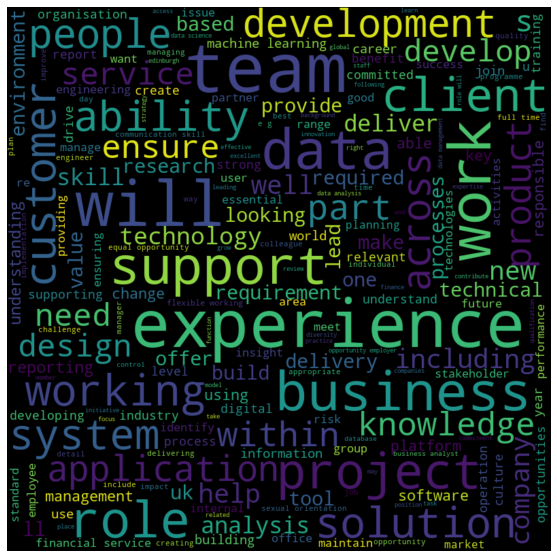

In [11]:
# Read the whole text.
text = ' '.join(df['description'].tolist())

# Generate a word cloud image
wordcloud = WordCloud(max_font_size=100, width=800, height=800).generate(text)
WordCloud()
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


Create a wordcloud for all jobtitle text only

Analyst, 

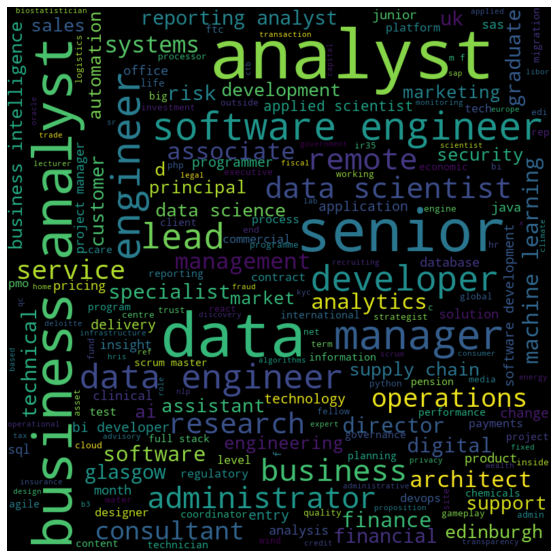

In [12]:
# Read the job title only]
text = ' '.join(df['title'].tolist())

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
wordcloud = WordCloud(max_font_size=100, width=800, height=800).generate(text)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


## Try using nltk freqdist
Start with just looking at the first job data entry

In [13]:
from nltk.probability import FreqDist

text = df.description.iloc[0]
text = nltk.word_tokenize(text)
fdist = FreqDist(text)

[print(x) for x in fdist.most_common(10)];

('and', 34)
(',', 27)
('to', 24)
('data', 19)
('you', 14)
('the', 13)
('a', 12)
('’', 12)
('of', 12)
('as', 11)


Lots of useless words in that list.  Lets remove all the standard English Stopwords

In [14]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

In [15]:
text = [x for x in text if x not in stop_words]
fdist = FreqDist(text)

[print(x) for x in fdist.most_common(10)];

(',', 27)
('data', 19)
('’', 12)
('experience', 10)
('.', 8)
('business', 7)
('analysis', 6)
('using', 5)
('science', 5)
('methods', 4)


This looks like it still includes punctuation, remove these entries to get a clearer picture of the top words in the dataset

In [16]:
text = [x for x in text if (x not in stop_words) & (x.isalpha())]
fdist = FreqDist(text)

[print(x) for x in fdist.most_common(10)];

('data', 19)
('experience', 10)
('business', 7)
('analysis', 6)
('using', 5)
('science', 5)
('methods', 4)
('work', 3)
('including', 3)
('also', 3)


# Information extraction
The objective here should be to try to extract info on skills.  So we can build a classifier that looks at the advert description text, and based on the list of skills identified

## Tokeni

In [119]:
def ie_preprocess(document):
    # Use list comprehension to 
#     sentences = [p for p in text.split('\n') if p]
    paras = []
    for para in document.split('\n'):
        paras.extend(nltk.sent_tokenize(para))
#         paras.append(para)
    sentences = paras    
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
#     sentences = [nltk.pos_tag(sent) for sent in sentences]
    return sentences
    
# Start from scratch
text = df.description.iloc[0]

a = ie_preprocess(text)
# pp = pprint.PrettyPrinter()
# pp.pprint(a)
a


[['we',
  "'re",
  'looking',
  'for',
  'a',
  'lead',
  'data',
  'scientist',
  'to',
  'join',
  'our',
  'glasgow',
  'team',
  'which',
  'specializes',
  'in',
  'natural',
  'language',
  'processing',
  'and',
  'tasks',
  'involving',
  'unstructured',
  'and',
  'semi-structured',
  'data.corporate',
  'technology',
  'machine',
  'learning',
  'is',
  'an',
  'applied',
  'research',
  'team',
  'that',
  'uses',
  'ai',
  'and',
  'machine',
  'learning',
  'to',
  'deliver',
  'innovative',
  'solutions',
  'across',
  'a',
  'diverse',
  'range',
  'of',
  'corporate',
  'functions',
  ':',
  'risk',
  ',',
  'compliance',
  ',',
  'finance',
  ',',
  'human',
  'resources',
  'and',
  'legal',
  '.'],
 ['together',
  'we',
  "'ll",
  'work',
  'with',
  'business',
  'and',
  'technology',
  'partners',
  'across',
  'the',
  'globe',
  ',',
  'to',
  'build',
  'imaginative',
  ',',
  'cutting-edge',
  'and',
  'well-engineered',
  'solutions',
  'that',
  'will',
  't

In [ ]:
grammar = "NP: {<DT>?<JJ>*<NN>}"

cp = nltk.RegexpParser(grammar)
result = cp.parse(a)

# Feature Engineering

## Add some binary features

In [152]:
mask = df.description.str.contains('python')
df['is_python'] = mask
df.is_python.sum()

162

In [154]:
mask = df.description.str.contains(r' r ', case=False, regex=True)
df['is_r'] = mask
df.is_r.sum()

16

In [155]:
mask = df.description.str.contains('spark')
df['is_spark'] = mask
df.is_spark.sum()

41

In [156]:
mask = df.description.str.contains('java')
df['is_java'] = mask
df.is_java.sum()

91

In [157]:
mask = df.description.str.contains('hadoop')
df['is_hadoop'] = mask
df.is_hadoop.sum()

25

In [160]:
mask = df.description.str.contains('aws|amazon web', regex=True)
df['is_aws'] = mask
df.is_aws.sum()

106

In [163]:
mask = df.description.str.contains('gcp|google cloud', regex=True)
df['is_gcp'] = mask
df.is_gcp.sum()

31

In [164]:
mask = df.description.str.contains('azure')
df['is_azure'] = mask
df.is_azure.sum()

66

In [178]:
mask = df.description.str.contains('nosql')
df['is_nosql'] = mask
df.is_nosql.sum()

16

In [182]:
mask = df.is_nosql==False & df.description.str.contains('sql')
# mask = mask & 
df['is_sql'] = mask
df.is_sql.sum()

689

In [183]:
mask = df.description.str.contains('mongodb')
df['is_mongodb'] = mask
df.is_mongodb.sum()

13

In [184]:
mask = df.description.str.contains('kubernetes')
df['is_kubernetes'] = mask
df.is_kubernetes.sum()

22

In [185]:
mask = df.description.str.contains('kafka')
df['is_kafka'] = mask
df.is_kafka.sum()

15

In [186]:
mask = df.description.str.contains('hive')
df['is_hive'] = mask
df.is_hive.sum()

14

In [187]:
mask = df.description.str.contains('nlp|natural language', regex=True)
df['is_nlp'] = mask
df.is_nlp.sum()

24

In [188]:
mask = df.description.str.contains('tensorflow')
df['is_tensorflow'] = mask
df.is_tensorflow.sum()

23

In [189]:
mask = df.description.str.contains('keras')
df['is_keras'] = mask
df.is_keras.sum()

3

In [190]:
mask = df.description.str.contains('pytorch')
df['is_pytorch'] = mask
df.is_pytorch.sum()

11

In [191]:
mask = df.description.str.contains('sklearn|sci-?kit-?learn', regex=True)
df['is_sklearn'] = mask
df.is_sklearn.sum()

13

In [195]:
mask = df.description.str.contains('deep learning')
df['is_deep_learning'] = mask
df.is_deep_learning.sum()

20

In [198]:
mask = df.description.str.contains('etl|extract[,-]? ?transform[,-]? ?load', regex=True)
df['is_etl'] = mask
df.is_etl.sum()

47

In [199]:
mask = df.description.str.contains('excel')
df['is_excel'] = mask
df.is_excel.sum()

406

In [200]:
mask = df.description.str.contains('machine learning')
df['is_ml'] = mask
df.is_ml.sum()

190

In [202]:
mask = df.description.str.contains('artificial intelligence')
df['is_ai'] = mask
df.is_ai.sum()

50

In [203]:
mask = df.description.str.contains('statistics|stats', regex=True)
df['is_stats'] = mask
df.is_stats.sum()

68

In [205]:
mask = df.description.str.contains('data[- ]?mining', regex=True)
df['is_data_mining'] = mask
df.is_data_mining.sum()

15

In [207]:
mask = df.description.str.contains('data[- ]?analysis|data[- ]?analytics', regex=True)
df['is_data_analysis'] = mask
df.is_data_analysis.sum()

153

In [208]:
mask = df.description.str.contains('big data')
df['is_bigdata'] = mask
df.is_bigdata.sum()

55

In [209]:
mask = df.description.str.contains('computer vision|machine vision')
df['is_comp_vision'] = mask
df.is_comp_vision.sum()

13

In [211]:
mask = df.description.str.contains('c\+\+')
df['is_c_plus_plus'] = mask
df.is_c_plus_plus.sum()

44

In [213]:
mask = df.description.str.contains(' sas ')
df['is_sas'] = mask
df.is_sas.sum()

12

In [214]:
mask = df.description.str.contains('matlab')
df['is_matlab'] = mask
df.is_matlab.sum()

13

In [214]:
mask = df.description.str.contains('tableau')
df['is_tableau'] = mask
df.is_tableau.sum()

13

In [217]:
mask = df.description.str.contains('power[- ]?bi', regex=True)
df['is_tableau'] = mask
df.is_tableau.sum()

52

In [219]:
mask = df.description.str.contains('prediction|predictive', regex=True)
df['is_predictive'] = mask
df.is_predictive.sum()

33

In [218]:
mask = df.description.str.contains('prediction|predictive')
df['is_predictive'] = mask
df.is_predictive.sum()

33

In [18]:
mask = df.description.str.contains('databricks')
df['is_databricks'] = mask
df.is_databricks.sum()

12

In [19]:
mask = df.description.str.contains('spark')
df['is_spark'] = mask
df.is_spark.sum()

41

In [20]:
mask = df.description.str.contains('aws') | df.description.str.contains('amazon')
df['is_aws'] = mask
df.is_aws.sum()

117

In [21]:
mask = df.description.str.contains('cloud')
df['is_cloud'] = mask
df.is_cloud.sum()

166

In [22]:
mask = df.description.str.contains('azure')
df['is_azure'] = mask
df.is_azure.sum()

66

In [23]:
mask = df.description.str.contains('gcp') | df.description.str.contains('google cloud') 
df['is_gcp'] = mask
df.is_gcp.sum()

31

In [24]:
df.head().T

,0,1,2,3,4
title,data scientist,data scientist,data scientist - nlp,data science analyst - consumer (remote),data scientist - ktp associate
id,44d7c15b1b5e4dc0,253c5778a472a487,d18cd05182b42142,21c37c6099516c69,bf2181782ab76a51
company,NatWest Group,Kleboe Jardine,Propel,Yelp,University of Strathclyde
url,https://uk.indeed.com/pagead/clk?mo=r&ad=-6NYl...,https://uk.indeed.com/company/Elliot-Dreghorn-...,https://uk.indeed.com/rc/clk?jk=d18cd05182b421...,https://uk.indeed.com/rc/clk?jk=21c37c6099516c...,https://uk.indeed.com/rc/clk?jk=bf2181782ab76a...
location,Edinburgh,Galashiels,Glasgow,Dundee,Glasgow
summary,"Experience with data science software, databas...",They maximise data utility to allow for innova...,You will be able to identify the best opportun...,A knack for communicating quantitative results...,The Department of Computer & Information Scien...
date,30+ days ago,9 days ago,30+ days ago,1 day ago,5 days ago
description,join us as a data scientist\nyou’ll be identif...,my client supports international organisations...,job overview\na product led healthtech start u...,"at yelp, it’s our mission to connect people wi...",salary range: up to £32-34k p.a. depending on ...
description_html,"<div class=""jobsearch-jobDescriptionText"" id=""...","<div class=""jobsearch-jobDescriptionText"" id=""...","<div class=""jobsearch-jobDescriptionText"" id=""...","<div class=""jobsearch-jobDescriptionText"" id=""...","<div class=""jobsearch-jobDescriptionText"" id=""..."
page_format,0,0,0,0,0
